<a href="https://colab.research.google.com/github/RoBorregos/home-pipelines/blob/vision-dataset/vision/object_detector/notebooks/dataset_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object detector dataset generator

With this notebook you'll be able to artificially generate and automatically label
a dataset for detecting objects. You can bring your own images or test it by fetching images from Kaggle hub.

If running on colab, install dependencies:

In [ ]:
!pip install numpy opencv-python pillow pycocotools pyyaml torch ultralytics matplotlib imutils argparse groundingdino-py segment-anything

If you want to mount your google drive for training with checkpoints in colab and saving your progress run the following cell:

In [1]:
!rm -rf /content/sample_data
!rm -rf /content/.config
from google.colab import drive
import os
drive.mount('/content', force_remount=True)
workdir = "/content/MyDrive/RoBorregos/vision/dataset_generator/"
os.makedirs(workdir, exist_ok=True)

Mounted at /content


If not mounting a drive run the next cell:

In [ ]:
workdir = "/content/"

In [2]:
import os
os.chdir("/")
import sys
import random
import json
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageEnhance, ImageFilter, ImageFont, UnidentifiedImageError
from pycocotools import mask
import json
import yaml
import csv
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import ultralytics
import time
import imutils
import argparse
from segment_anything import sam_model_registry, SamPredictor
import groundingdino.datasets.transforms as T
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.inference import load_model, predict
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from groundingdino.util.vl_utils import create_positive_map_from_span

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


# Attention!
If you have specific pictures, place the folders in ./images and skip the next two blocks of code which download a default dataset.

In [3]:
!pip install kagglehub
import kagglehub

dataset_path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

In [4]:
!cp -r {dataset_path}/PetImages {workdir}
!mv {workdir}/PetImages {workdir}/images

def clean_and_trim_dataset(folder):
    total_removed = 0

    for category in ["Cat", "Dog"]:
        path = os.path.join(folder, category)
        valid_images = []

        # Step 1: Remove corrupt images
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()
                valid_images.append(img_path)
            except (UnidentifiedImageError, OSError):
                os.remove(img_path)
                total_removed += 1

        print(f"Removed {total_removed} corrupt images from {category}")

        # Step 2: Remove part of the remaining valid images
        to_delete = random.sample(valid_images, len(valid_images) * 99 // 100)
        for img_path in to_delete:
            os.remove(img_path)

        print(f"Removed {len(to_delete)} images from {category} to reduce dataset size")

clean_and_trim_dataset(workdir + "images")

def count_files_in_dir(directory):
    # List all files (images) in the directory and count them
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return len(files)

# Example usage for "Cat" and "Dog" folders
cat_folder = workdir + "images/Cat"
dog_folder = workdir + "images/Dog"

print(f"Number of cat images: {count_files_in_dir(cat_folder)}")
print(f"Number of dog images: {count_files_in_dir(dog_folder)}")

Removed 0 corrupt images from Cat
Removed 12374 images from Cat to reduce dataset size


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Removed 0 corrupt images from Dog
Removed 12374 images from Dog to reduce dataset size
Number of cat images: 125
Number of dog images: 125


In [5]:
base_path = workdir + "images"
size = 720

for class_dir in os.listdir(base_path):
    class_path = os.path.join(base_path, class_dir)

    if not os.path.isdir(class_path):
        continue

    for filename in os.listdir(class_path):
        file_path = os.path.join(class_path, filename)

        try:
            with Image.open(file_path) as img:
                img = img.resize((size, size))
                img.save(file_path)
        except (UnidentifiedImageError, OSError) as e:
            print(f"Removing corrupt file: {file_path}")
            os.remove(file_path)  # delete corrupt image

os.chdir(workdir)

Removing corrupt file: /content/MyDrive/RoBorregos/vision/dataset_generator//images/Dog/2688.jpg


If you have already ran this and are using a volume/drive there is no need to run again.

In [6]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
!wget https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 463 (delta 175), reused 136 (delta 136), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 7.35 MiB/s, done.
Resolving deltas: 100% (241/241), done.
--2025-04-22 23:09:53--  https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/611591640/f221e500-c2fc-4fd3-b84e-8ad92a6923f3?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Credential=releaseassetproduction%2F20250422%2Fus-east-1%2Fs3%2Faws4_request&X-Amz-Date=20250422T230953Z&X-Amz-Expires=300&X-Amz-Signature=a4b36adfa315ebeb9cda31993793071

In [4]:
SAVE_BB = False
DEBUG = False

results_path = workdir + "processed" #path to save results already processed and segmented images
config_file = workdir + "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"  # change the path of the model config file
checkpoint_path = workdir + "groundingdino_swint_ogc.pth"  # change the path of the model
output_dir = results_path
box_threshold = 0.3
text_threshold = 0.25
token_spans = None

sys.path.append("..")
sam_model = "h"

#use sam model
#wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
#wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
if sam_model =="h":
  sam_checkpoint = workdir + "sam_vit_h_4b8939.pth"
  model_type = "vit_h"
else:
  sam_checkpoint = workdir + "sam_vit_l_0b3195.pth"
  model_type = "vit_l"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using", device)
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

images=[]
annotations=[]
categories=[]

img_id=0
anno_id=0

# Make a list of all the directories in the path
base_path = workdir + "images"
path_to_classes = [f.path for f in os.scandir(base_path) if f.is_dir()]

def load_image(image_path):

    image_pil = Image.open(image_path).convert("RGB")  # load image

    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image_pil, image


def load_model(model_config_path, model_checkpoint_path, cpu_only=False):
    args = SLConfig.fromfile(model_config_path)
    args.device = device
    model = build_model(args)
    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    load_res = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    if DEBUG:
        print(load_res)
    _ = model.eval()
    return model


def get_grounding_output(model, image, caption, box_threshold, text_threshold=None, with_logits=True, cpu_only=False, token_spans=None):
    assert text_threshold is not None or token_spans is not None, "text_threshould and token_spans should not be None at the same time!"
    caption = caption.lower()
    caption = caption.strip()
    if not caption.endswith("."):
        caption = caption + "."
    model = model.to(device)
    image = image.to(device)
    with torch.no_grad():
        if DEBUG:
            print("Running model...")
        outputs = model(image[None], captions=[caption])
    logits = outputs["pred_logits"].sigmoid()[0]  # (nq, 256)
    boxes = outputs["pred_boxes"][0]  # (nq, 4)

    # filter output
    if token_spans is None:
        logits_filt = logits.cpu().clone()
        boxes_filt = boxes.cpu().clone()
        filt_mask = logits_filt.max(dim=1)[0] > box_threshold
        logits_filt = logits_filt[filt_mask]  # num_filt, 256
        boxes_filt = boxes_filt[filt_mask]  # num_filt, 4

        # get phrase
        tokenlizer = model.tokenizer
        tokenized = tokenlizer(caption)
        # build pred
        pred_phrases = []
        for logit, box in zip(logits_filt, boxes_filt):
            pred_phrase = get_phrases_from_posmap(logit > text_threshold, tokenized, tokenlizer)
            if with_logits:
                pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")
            else:
                pred_phrases.append(pred_phrase)
    else:
        # given-phrase mode
        positive_maps = create_positive_map_from_span(
            model.tokenizer(text_prompt),
            token_span=token_spans
        ).to(image.device) # n_phrase, 256

        logits_for_phrases = positive_maps @ logits.T # n_phrase, nq
        all_logits = []
        all_phrases = []
        all_boxes = []
        for (token_span, logit_phr) in zip(token_spans, logits_for_phrases):
            # get phrase
            phrase = ' '.join([caption[_s:_e] for (_s, _e) in token_span])
            # get mask
            filt_mask = logit_phr > box_threshold
            # filt box
            all_boxes.append(boxes[filt_mask])
            # filt logits
            all_logits.append(logit_phr[filt_mask])
            if with_logits:
                logit_phr_num = logit_phr[filt_mask]
                all_phrases.extend([phrase + f"({str(logit.item())[:4]})" for logit in logit_phr_num])
            else:
                all_phrases.extend([phrase for _ in range(len(filt_mask))])
        boxes_filt = torch.cat(all_boxes, dim=0).cpu()
        pred_phrases = all_phrases
    return boxes_filt, pred_phrases


def verify_or_create_dir(path):
    os.makedirs(path, exist_ok=True)
    if DEBUG:
        print(f"Verified/created: {path}")


def count_all_files_in_dir(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len([f for f in files if os.path.isfile(os.path.join(root, f))])
    return count


# Get total number of images to process
image_dir = workdir + "images"
number_of_images = count_all_files_in_dir(image_dir)
print(f"Total image files: {number_of_images}")

# Check if results directory exists, else create it
verify_or_create_dir(results_path)

# Main loop
i = 0
for class_path in path_to_classes:
    imgPaths = os.listdir(class_path)
    if SAVE_BB:
        class_name = os.path.basename(class_path)
        verify_or_create_dir(f"{results_path}/bbs/{class_name}")

    for imgPath in imgPaths:
        if DEBUG:
            print(f"Processing image: {imgPath}")
        print(f"%{i * 100 / number_of_images}")
        img = imutils.resize(cv2.imread(f"{class_path}/{imgPath}"))
        if img is None:
            continue

    #------------------------start grounding----------------------------------------------

        # Image_path = args.image_path
        cpu_only = False if torch.cuda.is_available() else True

        # Load image
        image_pil, image = load_image(f"{class_path}/{imgPath}")

        # Load model
        model = load_model(config_file, checkpoint_path, cpu_only=cpu_only)

        # Set the text_threshold to None if token_spans is set.
        if token_spans is not None:
            text_threshold = None
            print("Using token_spans. Set the text_threshold to None.")

        # Run model
        text_prompt = os.path.basename(class_path)
        boxes_filt, pred_phrases = get_grounding_output(
            model, image, text_prompt, box_threshold, text_threshold, cpu_only=cpu_only, token_spans=eval(f"{token_spans}")
        )

        # Found bb dimensions

        size = image_pil.size
        pred_dict = {
            "boxes": boxes_filt,
            "size": [size[1], size[0]],  # H, W
            "labels": pred_phrases,
        }

        H, W = pred_dict["size"]
        boxes = pred_dict["boxes"]
        labels = pred_dict["labels"]
        assert len(boxes) == len(labels), "boxes and labels must have same length"

        draw = ImageDraw.Draw(image_pil)
        mask = Image.new("L", image_pil.size, 0)
        mask_draw = ImageDraw.Draw(mask)

        #change pil image to cv2 image
        img = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
        img2 = img.copy()
        # draw boxes and masks
        for box, label in zip(boxes, labels):
            # from 0..1 to 0..W, 0..H
            box = box * torch.Tensor([W, H, W, H])
            # from xywh to xyxy
            box[:2] -= box[2:] / 2
            box[2:] += box[:2]
            # random color
            color = tuple(np.random.randint(0, 255, size=1).tolist())
            # draw
            padding = 10
            x0, y0, x1, y1 = box
            x0, y0, x1, y1 = int(x0)-padding, int(y0)-padding, int(x1)+padding, int(y1)+padding

            #validate if the bounding box is inside the image
            if x0 < 0:
                x0 = 0
            if y0 < 0:
                y0 = 0
            if x1 > W:
                x1 = W
            if y1 > H:
                y1 = H

            #draw rectangles
            cv2.rectangle(img2, (x0, y0), (x1, y1), color, 2)

            draw.rectangle([x0, y0, x1, y1], outline=color, width=6)
            # draw.text((x0, y0), str(label), fill=color)

            font = ImageFont.load_default()
            if hasattr(font, "getbbox"):
                bbox = draw.textbbox((x0, y0), str(label), font)
            else:
                w, h = draw.textsize(str(label), font)
                bbox = (x0, y0, w + x0, y0 + h)
            # bbox = draw.textbbox((x0, y0), str(label))
            draw.rectangle(bbox, fill=color)
            draw.text((x0, y0), str(label), fill="white")

            mask_draw.rectangle([x0, y0, x1, y1], fill=255, width=6)

    # ----------------Start SAM--------------------------------------------------------------

            class_name = class_path.split("/")[-1]
            sam_bounding_box = np.array([x0, y0, x1, y1])
            ran_sam = False
            #run sam
            if ran_sam == False:
                predictor.set_image(img)
                ran_sam = True

            mask, _, _ = predictor.predict(
                point_coords=None,
                point_labels=None,
                box=sam_bounding_box,
                multimask_output=False,
            )

            mask, _, _ = predictor.predict(box=sam_bounding_box, multimask_output=False)

            # Make png mask
            contours, _ = cv2.findContours(mask[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # Your call to find the contours

            # threshold input image using otsu thresholding as mask and refine with morphology
            ret, pngmask = cv2.threshold(mask[0].astype(np.uint8), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            kernel = np.ones((9,9), np.uint8)
            pngmask = cv2.morphologyEx(pngmask, cv2.MORPH_CLOSE, kernel)
            pngmask = cv2.morphologyEx(pngmask, cv2.MORPH_OPEN, kernel)
            result = img.copy()
            result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
            result[:, :, 3] = pngmask

    # ----------------Save Images-----------------------------------------------------------------

            if SAVE_BB:
              cv2.imwrite(f"{results_path}/bbs/{class_name}/{imgPath}", img2)

            verify_or_create_dir(f"{results_path}/{class_name}")

            file_path = f"{results_path}/{class_name}/{imgPath[:-4]}.png"
            if os.path.exists(file_path):
                if os.path.exists(f"{results_path}/{class_name}/{imgPath[:-4]}_1.png"):
                    if DEBUG:
                        print("File already exists, saving with _2")
                    cv2.imwrite(f"{results_path}/{class_name}/{imgPath[:-4]}_2.png", result)
                else:
                    if DEBUG:
                        print("File already exists, saving with _1")
                    file_path = f"{results_path}/{class_name}/{imgPath[:-4]}_1.png"

            cv2.imwrite(file_path, result)
            i = i + 1
            ran_sam = False

Using cuda
Total image files: 249
%0.0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `

%0.40160642570281124
final text_encoder_type: bert-base-uncased
%0.8032128514056225
final text_encoder_type: bert-base-uncased
%2.4096385542168677
final text_encoder_type: bert-base-uncased
%2.8112449799196786
final text_encoder_type: bert-base-uncased
%3.21285140562249
final text_encoder_type: bert-base-uncased
%3.6144578313253013
final text_encoder_type: bert-base-uncased
%4.016064257028113
final text_encoder_type: bert-base-uncased
%4.417670682730924
final text_encoder_type: bert-base-uncased
%4.819277108433735
final text_encoder_type: bert-base-uncased
%5.220883534136546
final text_encoder_type: bert-base-uncased
%5.622489959839357
final text_encoder_type: bert-base-uncased
%6.024096385542169
final text_encoder_type: bert-base-uncased
%7.228915662650603
final text_encoder_type: bert-base-uncased
%7.6305220883534135
final text_encoder_type: bert-base-uncased
%8.032128514056225
final text_encoder_type: bert-base-uncased
%8.433734939759036
final text_encoder_type: bert-base-uncased
%8

In [ ]:
import os
from IPython.display import display, Image, Javascript, clear_output
import ipywidgets as widgets

# Step 1: Collect image paths
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp')
image_paths = [
    os.path.join(root, file)
    for root, _, files in os.walk('/content/processed')
    for file in files if file.lower().endswith(image_extensions)
]

# Step 2: Create widgets
output = widgets.Output()
hidden_input = widgets.Text(placeholder='Press k (keep) or d (delete)', layout=widgets.Layout(width='0px'))
keep_button = widgets.Button(description="Keep", button_style='success')
delete_button = widgets.Button(description="Delete", button_style='danger')

# Step 3: State management
index = {"i": 0}

def show_image():
    output.clear_output(wait=True)
    if index["i"] < len(image_paths):
        with output:
            display(Image(filename=image_paths[index["i"]], width=400))
            display(widgets.HBox([keep_button, delete_button]))
            hidden_input.value = ''  # Clear input for next key
            hidden_input.focus()
    else:
        with output:
            print("✅ All images reviewed!")

def keep_image(_=None):
    index["i"] += 1
    show_image()

def delete_image(_=None):
    try:
        os.remove(image_paths[index["i"]])
        print(f"🗑️ Deleted: {image_paths[index['i']]}")
    except Exception as e:
        print(f"⚠️ Error deleting file: {e}")
    index["i"] += 1
    show_image()

def handle_keypress(change):
    key = change["new"].lower()
    if key == 'k':
        keep_image()
    elif key == 'd':
        delete_image()

# Step 4: Bind events
keep_button.on_click(keep_image)
delete_button.on_click(delete_image)
hidden_input.observe(handle_keypress, names='value')

# Step 5: Inject JavaScript to forward keypresses to the hidden text widget
js_focus = Javascript("""
document.addEventListener("keydown", (e) => {
    const input = document.querySelector('input[placeholder="Press k (keep) or d (delete)"]');
    if (input) {
        input.value = e.key;
        input.dispatchEvent(new Event('input', { bubbles: true }));
    }
});
""")

# Step 6: Display everything
display(widgets.HTML("<b>Use 'k' to Keep, 'd' to Delete</b>"))
display(hidden_input)
display(js_focus)
display(output)
show_image()


HTML(value="<b>Use 'k' to Keep, 'd' to Delete</b>")

Text(value='', layout=Layout(width='0px'), placeholder='Press k (keep) or d (delete)')

<IPython.core.display.Javascript object>

Output()

In [ ]:
results_path = workdir + "DS_res/"
path_to_classes = [f.path for f in os.scandir(workdir + "processed") if f.is_dir()]

for class_path in path_to_classes:
    class_name = os.path.basename(class_path)
    verify_or_create_dir(results_path + class_name)
    for file_name in os.listdir(class_path):
        try:
            file_path = class_path + "/" + file_name
            my_image = Image.open(file_path)
            black = Image.new('RGBA', my_image.size)
            my_image = Image.composite(my_image, black, my_image)
            cropped_image = my_image.crop(my_image.getbbox())
            cropped_image.save(f"{results_path}{class_name}/{file_name}")
            print(f"{file_name} done")
        except Exception as e:
            print(f"{file_name} failed {e}")
            continue

6816.png done
7546.png done
2152.png done
7472.png done
9129.png done
425.png done
924.png done
5437.png done
8978.png done
7318.png done
585.png done
4586.png done
12043.png done
2138.png done
5592.png done
6587.png done
1314.png done
11765_1.png done
10663.png done
9473_2.png done
7916_1.png done
11616.png done
11933.png done
4119_1.png done
74.png done
6288.png done
105.png done
11737.png done
11765.png done
9358.png done
7368.png done
6505.png done
5961.png done
710_1.png done
11219.png done
2919.png done
4554.png done
9014.png done
1730.png done
4119.png done
5719.png done
8004.png done
3277.png done
2656.png done
9473.png done
9011.png done
2161.png done
7510.png done
9474.png done
7916.png done
4917.png done
10102.png done
11168.png done
7526.png done
9852.png done
2161_1.png done
6876.png done
6901.png done
10558.png done
7960.png done
11822.png done
3762.png done
2706.png done
7520.png done
12173.png done
8802.png done
3027.png done
1537.png done
3537.png done
2979.png done
12

In [ ]:
# Get all subfolders inside results_path
path_to_classes = [f.path for f in os.scandir(results_path) if f.is_dir() and "bbs" not in f.name]

# Build list of (path, class_name) tuples
fg_folders = [(path, os.path.basename(path)) for path in path_to_classes]

# Define folders
bg_folder = workdir + "bg/"
verify_or_create_dir(bg_folder)
output_folder = workdir + "ds_final/"

In [ ]:
objects_list = [os.path.basename(class_path) for class_path in path_to_classes]
annotations_ID = {}
categories = []
for i, object in enumerate(objects_list):
    annotations_ID[object] = i
    categories.append({"id": i, "name": object})

print(annotations_ID)
print(categories)

{'Cat': 0, 'Dog': 1}
[{'id': 0, 'name': 'Cat'}, {'id': 1, 'name': 'Dog'}]


In [ ]:
# Load the list of files in each of the three folders
fg_files = {}
for folder, category in fg_folders:
    fg_files[category] = os.listdir(folder)

In [ ]:
# Define the folder structure
subfolders = [
    "train/images",
    "train/labels",
    "test/images",
    "test/labels",
    "valid/images",
    "valid/labels",
]

# Create them
for sub in subfolders:
    verify_or_create_dir(os.path.join(output_folder, sub))

# Segment

NOT USED CURRENTLY

In [ ]:
# THIS IS HARD CODED STILL
import cv2

# Load the image from disk
image_path = "./DS_res/Cat/10076.png"
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on a copy of the original image
contour_image = image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

# Save the result
output_path = "./test.png"
cv2.imwrite(output_path, contour_image)
print(f"Saved contour image to {output_path}")


# Autolabel

For this step, add background images to ./bg

You can run the next 2 following blocks to download and format a default dataset.

In [ ]:
!pip install kagglehub
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("balraj98/stanford-background-dataset")

os.system(f'cp "{dataset_path}/images/"* {workdir}bg/')

Looking in indexes: http://jetson.webredirect.org/jp6/cu126, https://pypi.ngc.nvidia.com


0

In [ ]:
def clean_and_trim_dataset(folder):
    total_removed = 0
    valid_images = []

    # Step 1: Remove corrupt images
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        if not os.path.isfile(img_path):
            continue
        try:
            with Image.open(img_path) as img:
                img.verify()
            valid_images.append(img_path)
        except (UnidentifiedImageError, OSError):
            os.remove(img_path)
            total_removed += 1

    print(f"Removed {total_removed} corrupt images")

    # Step 2: Remove part of the remaining valid images
    to_delete = random.sample(valid_images, len(valid_images) * 0)
    for img_path in to_delete:
        os.remove(img_path)

    print(f"Removed {len(to_delete)} images to reduce dataset size")

def count_files_in_dir(directory):
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return len(files)

# Apply on /content/bg
clean_and_trim_dataset(workdir + "bg")

# Count remaining images
print(f"Remaining number of images: {count_files_in_dir(workdir + 'bg')}")


Removed 0 corrupt images
Removed 0 images to reduce dataset size
Remaining number of images: 715


In [ ]:
# UTIL DON'T RUN
!rm /content/ds_final/train/images/*
!rm /content/ds_final/train/labels/*

## Image generator

This cell takes the segmented images of the classes and backgrounds and generate images with a random amount of objects in them scattered around.

In [ ]:
images = []
annotations = []
annotations2 = []
annot_csv = []

img_id = int(0)
anno_id = int(0)

# Ratios at which these values will be modified
brightness_ratio = 0.05
saturation_ratio = 0.05
hue_ratio = 0.02
rescaling_min = 0.30
rescaling_max = 0.40

# Define the maximum overlap as a percentage
max_overlap_pct = 5

trainfolder = output_folder + "train/"
validfolder = output_folder + "valid/"

images_to_generate = 1500
max_objects_per_image = 5

for j in range(images_to_generate):
    with open(f'{trainfolder}labels/{img_id}.txt', 'w') as file:
        pass

    num_objects = random.randint(1, max_objects_per_image)
    fg_categories = random.choices(objects_list, k=num_objects)

    fg_files_selected = [[category, random.choice(fg_files[category])] for category in fg_categories]

    fg_imgs = []
    for img in fg_files_selected:
        folder = [f[0] for f in fg_folders if f[1] == img[0]][0]
        fg_imgs.append([img[0], Image.open(folder + "/" + img[1]), folder + img[1]])

    bg_files = os.listdir(bg_folder)
    bg_file = random.choice(bg_files)
    bg_img = Image.open(bg_folder + bg_file)

    occupied_mask = np.zeros((bg_img.height, bg_img.width), dtype=np.uint8)

    for img in fg_imgs:
        fg_img = img[1]

        angle = random.randint(-5, 5)
        scale = random.uniform(rescaling_min, rescaling_max)
        fg_img = fg_img.rotate(angle, resample=Image.BICUBIC, expand=True)
        fg_img = fg_img.resize((int(fg_img.width * scale), int(fg_img.height * scale)))

        MAX_OBJ_WIDTH = bg_img.width * 0.25
        MAX_OBJ_HEIGHT = bg_img.height * 0.25

        if fg_img.width > MAX_OBJ_WIDTH or fg_img.height > MAX_OBJ_HEIGHT:
            aspect_ratio = fg_img.width / fg_img.height
            if aspect_ratio >= 1:
                fg_img = fg_img.resize((int(MAX_OBJ_WIDTH), int(MAX_OBJ_WIDTH / aspect_ratio)))
            else:
                fg_img = fg_img.resize((int(MAX_OBJ_HEIGHT * aspect_ratio), int(MAX_OBJ_HEIGHT)))

        fg_img = ImageEnhance.Brightness(fg_img).enhance(random.uniform(0.7, 1.3))
        fg_img = ImageEnhance.Contrast(fg_img).enhance(random.uniform(0.9, 1.1))
        fg_img = ImageEnhance.Color(fg_img).enhance(random.uniform(0.7, 1.3))
        fg_img = fg_img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.0, 0.5)))

        img[1] = fg_img

        max_x = bg_img.width - fg_img.width
        max_y = bg_img.height - fg_img.height

        for attempt in range(50):
            x = random.randint(0, max_x)
            y = random.randint(0, max_y)

            fg_mask = np.array(fg_img.split()[-1]) > 0
            occ_crop = occupied_mask[y:y + fg_img.height, x:x + fg_img.width]
            overlap = np.sum(np.logical_and(fg_mask, occ_crop))
            allowed_overlap = max_overlap_pct / 100 * np.sum(fg_mask)

            if overlap <= allowed_overlap:
                occupied_mask[y:y + fg_img.height, x:x + fg_img.width] = np.logical_or(occ_crop, fg_mask)
                break
        else:
            continue

        seg_img = fg_img
        img_arr = np.array(seg_img)
        mask = img_arr[:, :, 3] != 0

        segmentation = []
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                if mask[i, j]:
                    segmentation.append(j + x)
                    segmentation.append(i + y)
        segmentation = [segmentation]

        area = abs(sum(
            segmentation[0][2 * i] * segmentation[0][(2 * i + 3) % len(segmentation[0])] -
            segmentation[0][(2 * i + 2) % len(segmentation[0])] * segmentation[0][2 * i + 1]
            for i in range(len(segmentation[0]) // 2)
        )) / 2

        bg_img.paste(fg_img, (x, y), fg_img)

        x1, y1 = x, y
        x2 = x + fg_img.width
        y2 = y + fg_img.height

        if x2 <= x1 or y2 <= y1:
            continue

        x_center_ann = ((x1 + x2) / 2) / bg_img.width
        y_center_ann = ((y1 + y2) / 2) / bg_img.height
        width_ann = (x2 - x1) / bg_img.width
        height_ann = (y2 - y1) / bg_img.height

        if not (0 <= x_center_ann <= 1 and 0 <= y_center_ann <= 1 and 0 <= width_ann <= 1 and 0 <= height_ann <= 1):
            continue

        with open(f'{trainfolder}labels/{img_id}.txt', 'a') as f:
            f.write(f"{annotations_ID[img[0]]} {x_center_ann} {y_center_ann} {width_ann} {height_ann}\n")

        annotations2.append({
            "id": anno_id, "image_id": img_id, "category_id": annotations_ID[img[0]],
            "bbox": [x, y, fg_img.width, fg_img.height],
            "segmentation": segmentation, "area": area, "iscrowd": 0
        })
        annotations.append({
            "id": anno_id, "image_id": img_id, "category_id": annotations_ID[img[0]],
            "bbox": [x, y, fg_img.width, fg_img.height],
            "segmentation": [], "area": fg_img.height * fg_img.width, "iscrowd": 0
        })
        annot_csv.append([
            "TRAIN", output_folder + str(img_id)+".jpg", img[0], x/bg_img.width, y/bg_img.height,
            "", "", (x+fg_img.width)/bg_img.width, (y+fg_img.height)/bg_img.height
        ])

        anno_id += 1

    bg_img.save(f"{trainfolder}images/" + str(img_id) + ".jpg", quality=100)
    images.append({"id": img_id, "file_name": str(img_id) + ".jpg", "height": bg_img.height, "width": bg_img.width})
    img_id += 1

# Create data.yaml
data = dict(
    train=f"{trainfolder}images",
    val=f"{validfolder}images",
    test=f"{validfolder}images",
    nc=len(annotations_ID),
    names=list(annotations_ID.keys())
)

with open(f'{output_folder}data.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)


## Check generated images

This cell shows 5 random images from the dataset and draws the bounding boxes from the labels.

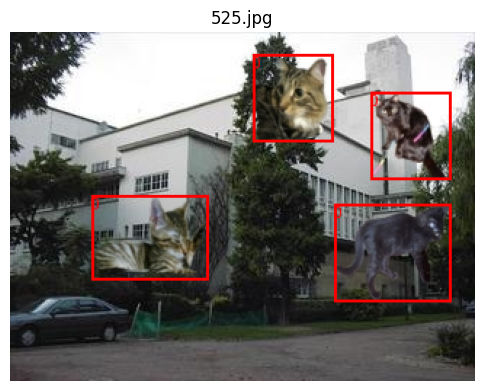

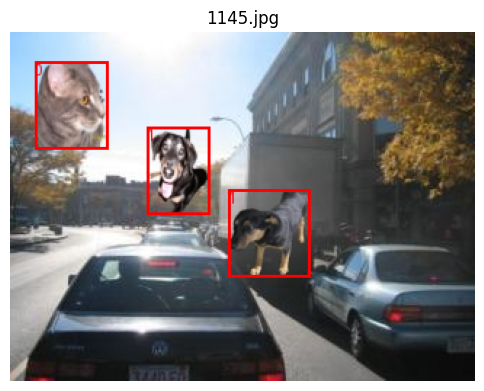

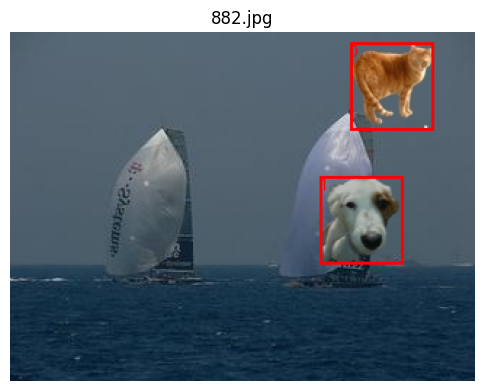

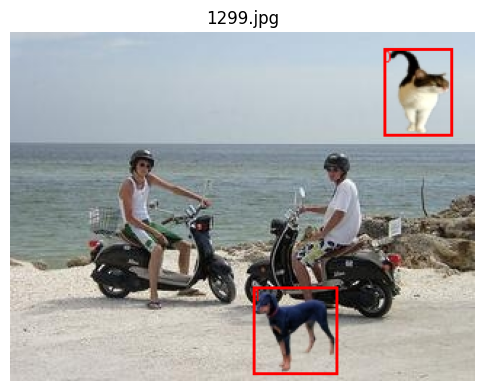

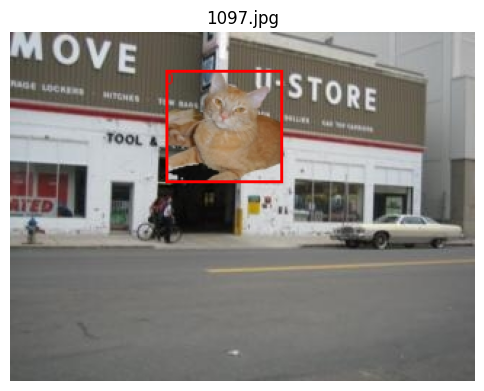

In [ ]:
# === CONFIG ===
images_dir = workdir + "ds_final/train/images"
labels_dir = workdir + "ds_final/train/labels"
num_samples = 5

# Get all image files
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]
sampled_files = random.sample(image_files, min(num_samples, len(image_files)))

for image_file in sampled_files:
    image_path = os.path.join(images_dir, image_file)
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(labels_dir, label_file)

    # Load image
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    img_width, img_height = image.size

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            labels = f.readlines()

        for label in labels:
            cls, x_center, y_center, w, h = map(float, label.strip().split())
            x_center *= img_width
            y_center *= img_height
            w *= img_width
            h *= img_height
            x0 = x_center - w / 2
            y0 = y_center - h / 2
            x1 = x_center + w / 2
            y1 = y_center + h / 2
            draw.rectangle([x0, y0, x1, y1], outline="red", width=2)
            draw.text((x0, y0), str(int(cls)), fill="red")

    # Show image with bounding boxes
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(image_file)
    plt.axis("off")
    plt.show()

## Split images

Take a percentage of the images and move them to test and validation directories.

In [ ]:
import os
import shutil
import random

validation = 0.1
test = 0.1

# Assumes test has 100% of data
output_folder = workdir + "/ds_final/"
trainfolder = output_folder + "train/"
trainfolderimgs = trainfolder + "images/"
trainfolderlabels = trainfolder + "labels/"
testfolder = output_folder + "test/"
testfolderimgs = testfolder + "images/"
testfolderlabels = testfolder + "labels/"
validfolder = output_folder + "valid/"
validfolderimgs = validfolder + "images/"
validfolderlabels = validfolder + "labels/"

fullSize = len(os.listdir(trainfolderimgs))
validSize = int(fullSize * validation)
testSize = int(fullSize * test)

for i in range(validSize):
    filelist = os.listdir(trainfolderimgs)
    #randomize file list, to not pick files in order
    random.shuffle(filelist)
    filetomove = filelist[i]
    #take out .jpg, .png, etc
    filetomovename = filetomove[:-4]
    #move images
    shutil.move(f"{trainfolderimgs}{filetomove}", f"{validfolderimgs}{filetomove}")
    #move labels
    shutil.move(f"{trainfolderlabels}{filetomovename}.txt", f"{validfolderlabels}{filetomovename}.txt")
for i in range(testSize):
    filetomove = os.listdir(trainfolderimgs)[i]
    #take out .jpg, .png, etc
    filetomovename = filetomove[:-4]
    #move images
    shutil.move(f"{trainfolderimgs}{filetomove}", f"{testfolderimgs}{filetomove}")
    #move labels
    shutil.move(f"{trainfolderlabels}{filetomovename}.txt", f"{testfolderlabels}{filetomovename}.txt")

#Validation
print(f"Train size is now: {len(os.listdir(trainfolderimgs))}")
print(f"Validation size is now: {len(os.listdir(validfolderimgs))}")
print(f"Test size is now: {len(os.listdir(testfolderimgs))}")

Train size is now: 1200
Validation size is now: 150
Test size is now: 150


## Train a yolo model with the dataset

In [ ]:
# UTIL DON'T RUN
!rm -rf runs

Clean invalid labels

In [ ]:
def clean_labels(split):
    label_dir = f'{workdir}ds_final/{split}/labels'
    if not os.path.exists(label_dir):
        print(f"Label directory for {split} not found.")
        return

    for label_file in os.listdir(label_dir):
        path = os.path.join(label_dir, label_file)
        with open(path, 'r') as f:
            lines = f.readlines()

        valid_lines = []
        for line in lines:
            try:
                parts = list(map(float, line.strip().split()))
                if len(parts) == 5:
                    _, x, y, w, h = parts
                    if all(0 <= val <= 1 for val in [x, y, w, h]):
                        valid_lines.append(line)
            except Exception as e:
                print(f"Error parsing line in {label_file}: {line} -> {e}")

        if valid_lines:
            with open(path, 'w') as f:
                f.writelines(valid_lines)
        else:
            os.remove(path)
            print(f"❌ Removed invalid label file: {path}")

# Clean labels for all splits
for split in ['train', 'test', 'valid']:
    print(f"🧹 Cleaning {split} labels...")
    clean_labels(split)

print("✅ Done cleaning labels!")


🧹 Cleaning train labels...
🧹 Cleaning test labels...
🧹 Cleaning valid labels...
✅ Done cleaning labels!


In [ ]:
!pip install ultralytics
from ultralytics import YOLO

# Load a YOLOv8 model (you can also use 'yolov8n.yaml', 'yolov8s.yaml', etc.)
model = YOLO("yolov8s.yaml")

# Train the model
model.train(
    data=workdir + "ds_final/data.yaml",
    epochs=100,
    imgsz=640,
    batch=16
)

Looking in indexes: http://jetson.webredirect.org/jp6/cu126, https://pypi.ngc.nvidia.com
Ultralytics 8.3.113 🚀 Python-3.10.12 torch-2.4.0 CUDA:0 (Orin, 62841MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/ds_final/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=Fal

train: Scanning /content/ds_final/train/labels.cache... 1200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1200/1200 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 736.8±480.8 MB/s, size: 47.9 KB)


val: Scanning /content/ds_final/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.77G     0.8091     0.6112      1.322        137        640: 100%|██████████| 75/75 [00:27<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        150        465      0.997      0.997      0.995      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.77G     0.7791     0.5912      1.303         79        640: 100%|██████████| 75/75 [00:28<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]

                   all        150        465      0.994      0.991      0.995      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.77G     0.7688     0.5944      1.292         93        640: 100%|██████████| 75/75 [00:27<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]

                   all        150        465      0.991      0.987      0.995      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.77G     0.7712     0.5696      1.282        100        640: 100%|██████████| 75/75 [00:27<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        150        465      0.993      0.989      0.995      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.77G     0.7594     0.5631      1.278         91        640: 100%|██████████| 75/75 [00:27<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

                   all        150        465      0.995      0.993      0.995      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.77G     0.7498     0.5658      1.272         93        640: 100%|██████████| 75/75 [00:28<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]

                   all        150        465      0.981      0.963      0.991      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.77G     0.7382     0.5412      1.248         88        640: 100%|██████████| 75/75 [00:27<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        150        465      0.994      0.998      0.995      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.77G     0.7229     0.5538      1.243        110        640: 100%|██████████| 75/75 [00:27<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]

                   all        150        465      0.993      0.997      0.995      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.77G     0.7115      0.523      1.234         86        640: 100%|██████████| 75/75 [00:27<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]

                   all        150        465      0.996      0.997      0.995      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.77G     0.7142     0.5206      1.236         79        640: 100%|██████████| 75/75 [00:27<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        150        465      0.991      0.992      0.995       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.77G     0.7011      0.516       1.23        101        640: 100%|██████████| 75/75 [00:28<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        150        465      0.996      0.998      0.995      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.77G     0.7088     0.5298       1.23         74        640: 100%|██████████| 75/75 [00:28<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        150        465      0.995      0.993      0.995      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.77G     0.6904     0.5084      1.216         77        640: 100%|██████████| 75/75 [00:27<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        150        465      0.995          1      0.995      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.77G     0.6839     0.5027       1.21         66        640: 100%|██████████| 75/75 [00:27<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]

                   all        150        465      0.999      0.998      0.995      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.77G     0.6872     0.5008      1.209         80        640: 100%|██████████| 75/75 [00:27<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        150        465      0.991      0.998      0.995      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.77G     0.6752     0.4887      1.197         92        640: 100%|██████████| 75/75 [00:28<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]

                   all        150        465      0.996      0.999      0.995      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.77G     0.6759     0.4984      1.202         88        640: 100%|██████████| 75/75 [00:28<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.55it/s]

                   all        150        465          1          1      0.995      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.77G     0.6728     0.4977      1.202         81        640: 100%|██████████| 75/75 [00:27<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        150        465      0.999          1      0.995      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.77G     0.6464     0.4721      1.175         83        640: 100%|██████████| 75/75 [00:28<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

                   all        150        465      0.998          1      0.995      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.77G      0.648     0.4666      1.173         96        640: 100%|██████████| 75/75 [00:27<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.56it/s]

                   all        150        465          1          1      0.995      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.77G     0.6339     0.4623      1.165         82        640: 100%|██████████| 75/75 [00:28<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]

                   all        150        465      0.991      0.996      0.995      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.77G     0.6472     0.4729      1.182         88        640: 100%|██████████| 75/75 [00:28<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.41it/s]

                   all        150        465      0.994      0.999      0.995      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.77G     0.6412     0.4605      1.173        104        640: 100%|██████████| 75/75 [00:28<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        150        465      0.999      0.998      0.995      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.77G     0.6462      0.455       1.18        101        640: 100%|██████████| 75/75 [00:28<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]

                   all        150        465      0.997          1      0.995      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.77G     0.6233     0.4438      1.152         72        640: 100%|██████████| 75/75 [00:28<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        150        465      0.999      0.999      0.995      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.77G     0.6253     0.4478      1.156         80        640: 100%|██████████| 75/75 [00:27<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]

                   all        150        465          1          1      0.995      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.77G      0.619     0.4409       1.15        100        640: 100%|██████████| 75/75 [00:27<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        150        465      0.999          1      0.995      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.77G     0.6124     0.4411       1.15        103        640: 100%|██████████| 75/75 [00:27<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]

                   all        150        465      0.998      0.998      0.995      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.77G     0.6122     0.4417      1.146        121        640: 100%|██████████| 75/75 [00:28<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]

                   all        150        465      0.999          1      0.995        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.77G     0.6065     0.4299      1.145         76        640: 100%|██████████| 75/75 [00:28<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

                   all        150        465      0.999          1      0.995      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.77G     0.5985     0.4198      1.132         76        640: 100%|██████████| 75/75 [00:28<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        150        465          1          1      0.995      0.897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.77G      0.599     0.4202      1.135        102        640: 100%|██████████| 75/75 [00:27<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]

                   all        150        465      0.999          1      0.995      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.77G     0.5894     0.4246      1.133        100        640: 100%|██████████| 75/75 [00:27<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        150        465      0.999          1      0.995      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.77G     0.5916     0.4177       1.13         86        640: 100%|██████████| 75/75 [00:28<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        150        465          1          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.77G     0.5853     0.4082      1.122        102        640: 100%|██████████| 75/75 [00:28<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        150        465      0.996          1      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.77G     0.5707     0.3981      1.103         65        640: 100%|██████████| 75/75 [00:27<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

                   all        150        465      0.999          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.77G      0.573     0.4018      1.117         98        640: 100%|██████████| 75/75 [00:28<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        150        465      0.998      0.995      0.995      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.77G     0.5682     0.3969      1.108         97        640: 100%|██████████| 75/75 [00:28<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]

                   all        150        465      0.999          1      0.995      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.77G     0.5772     0.4027       1.11         73        640: 100%|██████████| 75/75 [00:28<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        150        465          1          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.77G     0.5765     0.4037      1.115        100        640: 100%|██████████| 75/75 [00:27<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]

                   all        150        465          1          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.77G     0.5763     0.4035      1.114         68        640: 100%|██████████| 75/75 [00:27<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        150        465      0.999          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.77G       0.56     0.3911        1.1        102        640: 100%|██████████| 75/75 [00:27<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]

                   all        150        465      0.999          1      0.995      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.77G     0.5556     0.3911      1.095         80        640: 100%|██████████| 75/75 [00:27<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        150        465      0.999          1      0.995      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.77G     0.5544     0.3924      1.099         88        640: 100%|██████████| 75/75 [00:28<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        150        465      0.999      0.998      0.995      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.77G      0.555     0.3884      1.099         84        640: 100%|██████████| 75/75 [00:27<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

                   all        150        465          1          1      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.77G     0.5455     0.3762       1.09         86        640: 100%|██████████| 75/75 [00:27<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all        150        465          1          1      0.995      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.77G     0.5512     0.3787      1.088         80        640: 100%|██████████| 75/75 [00:27<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]

                   all        150        465      0.999          1      0.995      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.77G     0.5304     0.3726      1.079         96        640: 100%|██████████| 75/75 [00:27<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        150        465      0.999          1      0.995      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.77G     0.5404     0.3821      1.088         99        640: 100%|██████████| 75/75 [00:27<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]

                   all        150        465      0.997          1      0.995      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.77G     0.5344     0.3741      1.079         81        640: 100%|██████████| 75/75 [00:28<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]

                   all        150        465      0.996          1      0.995      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.77G     0.5324     0.3732      1.077         93        640: 100%|██████████| 75/75 [00:27<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

                   all        150        465          1          1      0.995      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.77G     0.5233     0.3664      1.073         96        640: 100%|██████████| 75/75 [00:27<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]

                   all        150        465          1          1      0.995      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.77G     0.5232     0.3696      1.074        103        640: 100%|██████████| 75/75 [00:28<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]

                   all        150        465          1          1      0.995      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.77G     0.5124      0.361      1.066         85        640: 100%|██████████| 75/75 [00:27<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]

                   all        150        465      0.999          1      0.995      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.77G     0.5136     0.3582      1.067         98        640: 100%|██████████| 75/75 [00:27<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        150        465      0.999          1      0.995      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.77G     0.5048     0.3514      1.066         78        640: 100%|██████████| 75/75 [00:27<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.50it/s]

                   all        150        465          1          1      0.995      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.77G     0.5191     0.3639      1.071         80        640: 100%|██████████| 75/75 [00:27<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

                   all        150        465          1          1      0.995      0.918


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.77G      0.413      0.259     0.9895         50        640: 100%|██████████| 75/75 [00:28<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]

                   all        150        465          1          1      0.995      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.77G     0.4019     0.2459     0.9795         45        640: 100%|██████████| 75/75 [00:27<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.43it/s]

                   all        150        465          1          1      0.995      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.77G     0.3967     0.2385      0.973         54        640: 100%|██████████| 75/75 [00:27<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        150        465          1          1      0.995      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.77G     0.3937     0.2376     0.9721         50        640: 100%|██████████| 75/75 [00:27<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        150        465          1          1      0.995      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.77G     0.3867     0.2393     0.9729         49        640: 100%|██████████| 75/75 [00:27<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        150        465      0.999          1      0.995      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.77G     0.3891     0.2353     0.9736         55        640: 100%|██████████| 75/75 [00:28<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.44it/s]

                   all        150        465          1          1      0.995      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.77G     0.3842     0.2369     0.9714         42        640: 100%|██████████| 75/75 [00:28<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.40it/s]

                   all        150        465          1          1      0.995      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.77G     0.3816     0.2337     0.9641         35        640: 100%|██████████| 75/75 [00:27<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

                   all        150        465          1          1      0.995      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.77G     0.3703     0.2296     0.9549         43        640: 100%|██████████| 75/75 [00:27<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.39it/s]

                   all        150        465          1          1      0.995      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.77G      0.373     0.2248     0.9541         55        640: 100%|██████████| 75/75 [00:27<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

                   all        150        465          1          1      0.995      0.924



100 epochs completed in 0.854 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.113 🚀 Python-3.10.12 torch-2.4.0 CUDA:0 (Orin, 62841MiB)
YOLOv8s summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


                   all        150        465          1          1      0.995      0.925
                   Cat        125        235          1          1      0.995      0.922
                   Dog        117        230          1          1      0.995      0.927
Speed: 0.8ms preprocess, 6.5ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0xfffde81b1810>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
# Test the model
#model.val(data="ds_final/data.yaml", split="test")

# Load the best trained model
model = YOLO(workdir + "notebooks/runs/detect/train/weights/best.pt")

# Run inference on test images
results = model.predict(source=workdir + "ds_final/test/images", save=True, conf=0.25)


image 1/154 /content/ds_final/test/images/1.jpg: 480x640 2 Cats, 1 Dog, 17.3ms
image 2/154 /content/ds_final/test/images/1016.jpg: 480x640 1 Cat, 15.5ms
image 3/154 /content/ds_final/test/images/1022.jpg: 480x640 4 Cats, 27.5ms
image 4/154 /content/ds_final/test/images/1033.jpg: 480x640 2 Cats, 1 Dog, 28.3ms
image 5/154 /content/ds_final/test/images/1046.jpg: 480x640 3 Cats, 28.2ms
image 6/154 /content/ds_final/test/images/1058.jpg: 480x640 2 Cats, 2 Dogs, 28.3ms
image 7/154 /content/ds_final/test/images/1073.jpg: 480x640 1 Cat, 28.5ms
image 8/154 /content/ds_final/test/images/1076.jpg: 480x640 2 Cats, 28.2ms
image 9/154 /content/ds_final/test/images/1078.jpg: 480x640 1 Cat, 2 Dogs, 28.2ms
image 10/154 /content/ds_final/test/images/1094.jpg: 448x640 2 Cats, 2 Dogs, 28.9ms
image 11/154 /content/ds_final/test/images/1100.jpg: 512x640 1 Cat, 30.1ms
image 12/154 /content/ds_final/test/images/1101.jpg: 480x640 1 Cat, 1 Dog, 29.8ms
image 13/154 /content/ds_final/test/images/1102.jpg: 448x64

TODO:

* Images are too cropped outside.
* Truncate labels.
* Not overlap too much.
* Better segment objects?
* Limit size of objects.